Actor Critic Floater
---

In [478]:
import tensorflow as tf
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [466]:
class Floater:
    def __init__(self, mass = 1., g = 9.81, time_step = 0.1, init_velocity = np.array([0.,0.])):
        self.mass = mass
        self.time_step = time_step
        self.g = np.array([0.,-g])
        self.stopwatch = 0.
        
        self.position = np.array([0.,0.])        
        self.hist_position = [self.position]
        
        self.velocity = init_velocity
        self.hist_velocity = [self.velocity]
        
    ########
    # forces
    ########
        
    def apply_gravity(self):
        dv = self.g * self.time_step
        self.velocity = self.velocity + dv
        return self.velocity
        
    def apply_forces(self):
        self.apply_gravity()
        return self.velocity
        
    def update_history(self):
        self.hist_position.append(self.position)
        self.hist_velocity.append(self.velocity)
        return self.hist_position, self.hist_velocity
        
    #########
    # advance
    #########
        
    def advance(self):
        self.apply_forces()
        self.position = self.position + self.velocity * self.time_step
        self.stopwatch = self.stopwatch + self.time_step
        self.update_history()
        return self.position
    
    def above_ground(self, ground_level = 0.):
        if self.position[1] > ground_level:
            return True
        else:
            return False
        
    #########
    # viewing
    #########
    
    def plot_trajectory(self, figsize = (12,12), color = 1., to_show = False, xlims = None, ylims=None, label = None):
        if to_show:
            plt.figure(figsize = figsize)
        positions = np.array(self.hist_position)
        x = positions[:,0]
        y = positions[:,1]
        plt.plot(x, y, color = str(color), label = label)
        if to_show:
            plt.show()
    
    def plot_velocity(self, figsize = (12,12), color = 1., to_show = False, xlims = None, ylims=None, label = None):
        if to_show:
            plt.figure(figsize = figsize)
        velocities = np.array(self.hist_velocity)
        x = velocities[:,0]
        y = velocities[:,1]
        plt.plot(x, y, color = str(color))
        if to_show:
            plt.show();

class Rocket(Floater):
    def __init__(self, isp = 800., fuel_rate = 0.01, dry_mass = 1., g = 9.81, time_step = 0.1, init_velocity = np.array([0.,0.]), wet_mass = 10.):
        super().__init__(mass = dry_mass, g = g, time_step = time_step, init_velocity = init_velocity)
        
        #################
        # engine and fuel
        #################
        
        self.dry_mass = dry_mass
        self.wet_mass = wet_mass
        self.fuel_rate = fuel_rate
        self.isp = isp
        self.fuel_empty = False
        
        #has warned already about a weak engine
        self.not_warned = True
        
        right = np.array([1,0])
        up = np.array([0,1])
        self.directions = {
            1:right,
            2:up,
            3:-right,
            4:-up
        }
        
    def fire(self, direction_code):
        direction = self.directions[direction_code]
        fuel_used = self.fuel_rate * self.time_step
        if fuel_used > self.wet_mass:
            fuel_used = self.wet_mass
        if self.wet_mass == 0. and not self.fuel_empty:
            self.fuel_empty = True
            print(f'Rocket out of fuel at {self.stopwatch}')
        self.wet_mass = self.wet_mass - fuel_used
        impulse = fuel_used * self.isp * np.linalg.norm(self.g) * direction
        dv = impulse/(self.wet_mass + self.dry_mass)
        self.velocity = self.velocity + dv
        if self.not_warned and not self.fuel_empty and np.linalg.norm(dv) < 2*np.linalg.norm(self.g*self.time_step):
            self.not_warned = not self.not_warned
            print(f'Warning: Rocket TWR is {np.linalg.norm(dv)/np.linalg.norm(self.g*self.time_step)}')
            if np.linalg.norm(dv) < np.linalg.norm(self.g*self.time_step):
                print(f'Rocket cannot support itself.')
                
        return self.velocity
    
    def get_state(self):
        state = [rocket.position, rocket.velocity, [rocket.dry_mass, rocket.wet_mass]]
        state = tf.convert_to_tensor(state)
        state = tf.reshape(state, (1,6))
        return state

        

Rocket out of fuel at 100.09999999999859
1499.9999999997312


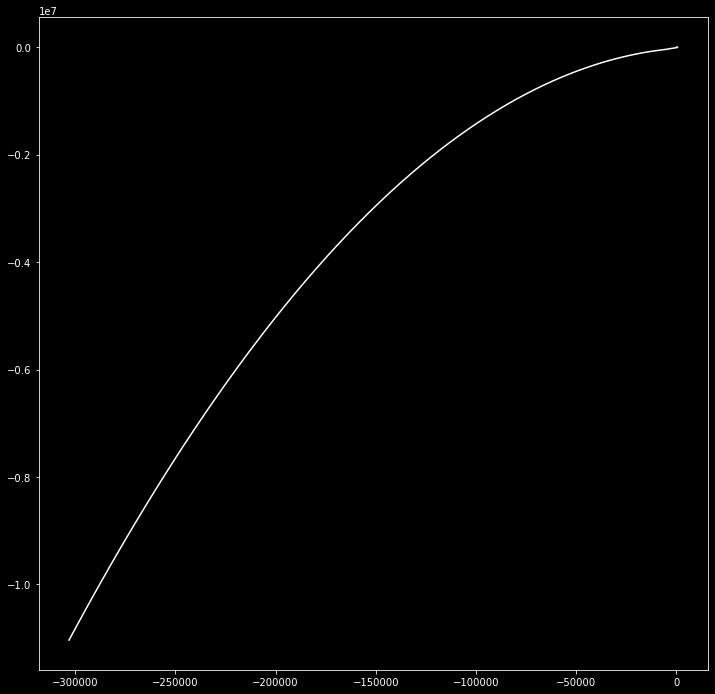

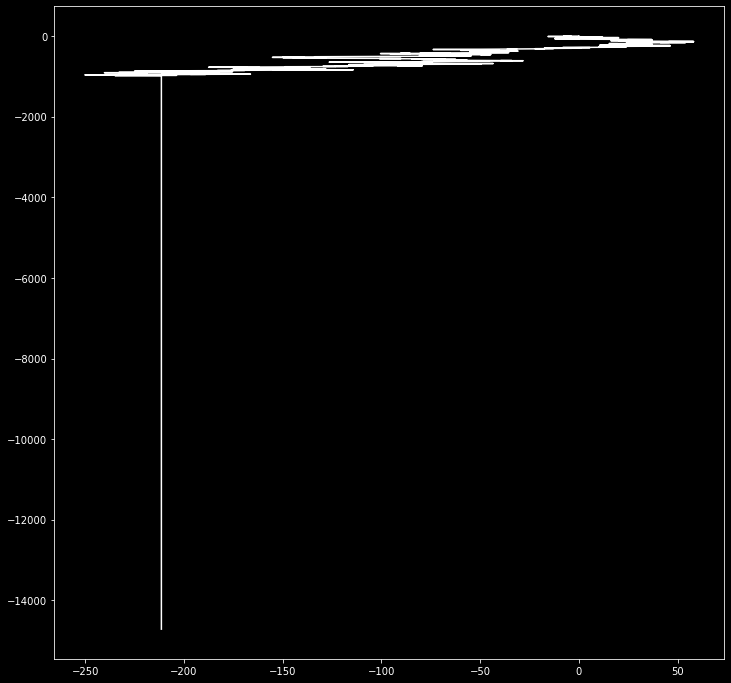

In [469]:
## see if the rocket is functioning properly

seed = 202231
rng = np.random.default_rng(seed)

vel = np.array([0.,0.])
flt = Rocket(init_velocity = vel, wet_mass=1)

prob_list = np.array(list(flt.directions.keys())[::-1])/sum(range(1,5))
prob_list = [0.5,0,0.5,0]

for step in range(15000):
    flt.advance()
    direction = rng.choice(range(1,5), p=prob_list )
    flt.fire(direction)
print(flt.stopwatch)
flt.plot_trajectory(to_show = True)
flt.plot_velocity(to_show = True)
    

In [486]:
class Pilot(tf.keras.Model):
    def __init__(self, num_outputs = 5, common_layer_size = 128):
        super().__init__()
        tf.random.set_seed(0)
        self.common1 = tf.keras.layers.Dense(common_layer_size, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.actor = tf.keras.layers.Dense(num_outputs, activation='softmax')
        self.critic = tf.keras.layers.Dense(1)

    def call(self, inputs, training=False):
        x = self.common1(inputs)
        if training:
            x = self.dropout(x, training=training)
        return tf.squeeze(self.actor(x)), tf.squeeze(self.critic(x))

In [487]:
seed = 20224
rng = np.random.default_rng(seed)

In [488]:
num_actions = 5
pilot = Pilot(num_outputs=num_actions)

Epoch 3, total loss 11417585.00, remaining fuel 9.110, time 20.00 sec
Epoch 6, total loss 11800497.00, remaining fuel 9.120, time 20.00 sec
Epoch 9, total loss 11173560.00, remaining fuel 9.125, time 20.00 sec
Epoch 12, total loss 9871066.00, remaining fuel 9.175, time 20.00 sec
Epoch 15, total loss 10523041.00, remaining fuel 9.175, time 20.00 sec
Epoch 18, total loss 8752203.00, remaining fuel 9.235, time 20.00 sec
Epoch 21, total loss 7897259.50, remaining fuel 9.290, time 20.00 sec
Epoch 24, total loss 5853812.50, remaining fuel 9.420, time 20.00 sec
Epoch 27, total loss 8184270.00, remaining fuel 9.315, time 20.00 sec
Epoch 30, total loss 6147550.50, remaining fuel 9.365, time 20.00 sec
Epoch 33, total loss 7465193.00, remaining fuel 9.325, time 20.00 sec
Epoch 36, total loss 4657925.00, remaining fuel 9.425, time 20.00 sec
Epoch 39, total loss 6162233.00, remaining fuel 9.405, time 20.00 sec
Epoch 42, total loss 5775063.00, remaining fuel 9.350, time 20.00 sec
Epoch 45, total los

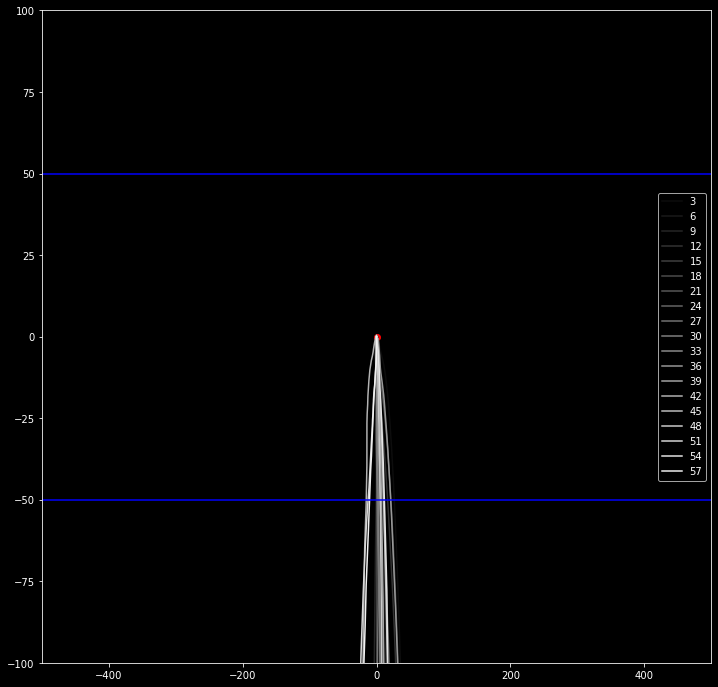

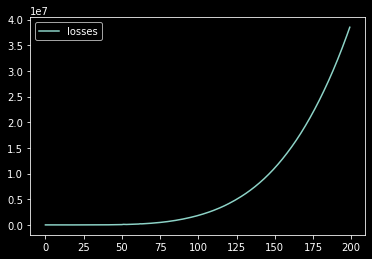

4    7952
0    3217
3     308
1     210
2     113
dtype: int64

In [489]:


learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

huber = tf.losses.Huber()

target_altitude = -50.

num_epochs = 60
num_updates = 20
update_period = num_epochs // num_updates
epoch_count = 0.

max_time = 20.



plt.figure(figsize = (12,12))

all_action_history = []
for epoch in range(1,num_epochs):
    init_vel = rng.random(2) - np.array([0.5,0.])
    rocket = Rocket(time_step = 0.1, fuel_rate=0.05, init_velocity=init_vel)
    state = rocket.get_state()
    with tf.GradientTape() as tape:
        errors_history = []
        critic_values_history = []
        action_probs_history= []
        while rocket.above_ground(-1000000.) and rocket.stopwatch < max_time:
            action_probs, critic_value = pilot.call(state, training=True)
            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            action_prob = action_probs[action]
            if action == 0:
                pass
            else:
                rocket.fire(action)
            all_action_history.append(action)
            rocket.advance()
            state = rocket.get_state()
            
            errors_history.append((rocket.position[1] - target_altitude)**2)
            critic_values_history.append(critic_value)
            action_probs_history.append(action_prob)
            
        losses = []
        for error, critic_value, action_prob in zip(errors_history, critic_values_history, action_probs_history):
            critic_error = huber([error], [critic_value])
            losses.append( -tf.math.log(action_prob)*critic_error + critic_error)
        sum_losses = tf.reduce_mean(losses)
        grads = tape.gradient(sum_losses, pilot.trainable_variables)
        optimizer.apply_gradients(zip(grads, pilot.trainable_variables))

    if epoch%update_period == 0:
        rocket.plot_trajectory(color = epoch/num_epochs, label = str(epoch))#, rocket.plot_velocity(True, color = epoch/num_epochs)
        template = 'Epoch {}, total loss {:.2f}, remaining fuel {:.3f}, time {:.2f} sec'
        print(template.format(epoch, sum_losses, rocket.wet_mass, rocket.stopwatch))
plt.legend();
plt.xlim(-500,500)
plt.ylim(-100,100)
plt.axhline(-50, color = 'blue')
plt.axhline(50, color = 'blue')
plt.scatter([[0]], [[0]], color = 'red')
plt.show()

plt.plot(losses, label = 'losses')
# plt.plot(critic_losses, label = 'actor losses')
# plt.plot(actor_losses, label = 'critic_losses')
plt.legend()
plt.show();

pd.Series(all_action_history).value_counts()